In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
from torch.autograd import Variable
import time

In [2]:
class TreeGRUStep(nn.Module):
    def __init__(self, sub_no, H_no, device):
        super().__init__()
        self.sub_no = sub_no
        self.H_no = H_no
        self.device = device
        
        self.W_hir = nn.Parameter(torch.randn(sub_no,H_no,2)*0.01)
        self.W_hii = nn.Parameter(torch.randn(sub_no,H_no,2)*0.01)
        self.W_hin = nn.Parameter(torch.randn(sub_no,H_no,2)*0.01)
        self.W_hhr = nn.Parameter(torch.randn(sub_no,H_no,H_no)*0.01)
        self.W_hhi = nn.Parameter(torch.randn(sub_no,H_no,H_no)*0.01)
        self.W_hhn = nn.Parameter(torch.randn(sub_no,H_no,H_no)*0.01)
        
        self.bias_ih = nn.Parameter(torch.randn(3*sub_no * H_no)*0.01)
        self.bias_hh = nn.Parameter(torch.randn(3*sub_no * H_no)*0.01)
        
    def forward(self, full_in, hidden):
        
        W_hi = torch.zeros(self.sub_no*self.H_no*3, self.sub_no*2).to(self.device)
        W_hh = torch.zeros(self.sub_no*self.H_no*3, self.sub_no*self.H_no).to(self.device)
        for s in range(self.sub_no):
            W_hi[s*self.H_no:(s+1)*self.H_no,s*2:(s+1)*2] = W_hi[s*self.H_no:(s+1)*self.H_no,s*2:(s+1)*2] + self.W_hir[s]
            W_hi[(s+self.sub_no)*self.H_no:(s+self.sub_no+1)*self.H_no,s*2:(s+1)*2] = W_hi[(s+self.sub_no)*self.H_no:(s+self.sub_no+1)*self.H_no,s*2:(s+1)*2] + self.W_hii[s]
            W_hi[(s+2*self.sub_no)*self.H_no:(s+2*self.sub_no+1)*self.H_no,s*2:(s+1)*2] = W_hi[(s+2*self.sub_no)*self.H_no:(s+2*self.sub_no+1)*self.H_no,s*2:(s+1)*2] + self.W_hin[s]
            
            W_hh[s*self.H_no:(s+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] = W_hh[s*self.H_no:(s+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] + self.W_hhr[s]
            W_hh[(s+self.sub_no)*self.H_no:(s+self.sub_no+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] = W_hh[(s+self.sub_no)*self.H_no:(s+self.sub_no+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] + self.W_hhr[s]
            W_hh[(s+2*self.sub_no)*self.H_no:(s+2*self.sub_no+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] = W_hh[(s+2*self.sub_no)*self.H_no:(s+2*self.sub_no+1)*self.H_no, s*self.H_no:(s+1)*self.H_no] + self.W_hhn[s]
        
        gi = F.linear(full_in, W_hi, self.bias_ih)
        gh = F.linear(hidden, W_hh, self.bias_hh)
        i_r, i_i, i_n = gi.chunk(3, 1)
        h_r, h_i, h_n = gh.chunk(3, 1)
            
        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + resetgate * h_n)
        hidden = newgate + inputgate * (hidden - newgate)
        
        return hidden #(B,sub*H)

class TreeGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, batch_size, device):
        super().__init__()
        
        self.sub_no = sub_no
        self.E_no = E_no
        self.I_no = I_no
        self.device = device
        self.H_no = H_no
        self.batch_size = batch_size
        
        ## C Parameters ###
        self.C_syn_e_logit = nn.Parameter(torch.zeros(self.sub_no, self.E_no))
        self.C_syn_i_logit = nn.Parameter(torch.zeros(self.sub_no, self.I_no))
        self.C_den_raw = nn.Parameter(torch.zeros(self.sub_no*(self.sub_no-1)//2-1))
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no))
        self.I_scale = nn.Parameter(torch.zeros(self.I_no))
        
        self.V_o = nn.Parameter(torch.zeros(1))
        
        rand_in = torch.randn(batch_size, 2*self.sub_no).to(device)
        rand_hid = torch.randn(batch_size, self.sub_no*self.H_no).to(device)
        
        step_model = TreeGRUStep(sub_no, H_no, device).to(device)
        self.rnn_step = torch.jit.trace(step_model, (rand_in, rand_hid))
                
    def forward(self, S_e, S_i, temp):
        T_data = S_e.shape[1]
        
        S_e = S_e * torch.exp(self.E_scale).reshape(1,1,-1)
        S_i = S_i * torch.exp(self.I_scale).reshape(1,1,-1)*(-1)
        
        C_syn_e = F.softmax((self.C_syn_e_logit) / temp, dim=0)
        C_syn_i = F.softmax((self.C_syn_i_logit) / temp, dim=0)
        C_den = torch.zeros(self.sub_no, self.sub_no).to(self.device)
        C_den[0,1] = 1
        den_count = 0
        for i in range(self.sub_no-2):
            C_den[:i+2,i+2] = C_den[:i+2,i+2] + F.softmax(self.C_den_raw[den_count:den_count+i+2] / temp , dim=0)
            den_count += i+2
            
        sub_out = torch.ones(self.batch_size, T_data, self.sub_no).to(self.device)
        S_e_sub = torch.matmul(S_e, C_syn_e.T.unsqueeze(0)) #(batch,T,sub)
        S_i_sub = torch.matmul(S_i, C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub #(batch,T,sub)
        
        hidden = torch.zeros(self.batch_size, self.H_no*self.sub_no).to(self.device)
        sub_t = torch.zeros(self.batch_size, self.sub_no).to(self.device)
        sub_sum = torch.zeros(self.sub_no, self.H_no*self.sub_no).to(self.device)
        for s in range(self.sub_no):
            sub_sum[s,s*self.H_no:(s+1)*self.H_no] = 1
        odd_idx = torch.arange(1,self.sub_no*2,2).to(self.device)
        even_idx = torch.arange(0,self.sub_no*2,2).to(self.device)
            
        for i, input_t in enumerate(torch.split(S_sub, 1, 1)): #(batch,sub)   
            full_in = torch.zeros(self.batch_size, self.sub_no*2).to(self.device)
            full_in[:,even_idx] = full_in[:,even_idx] + input_t.squeeze(1)
            full_in[:,odd_idx] = full_in[:,odd_idx] + torch.matmul(sub_t, C_den.T)
            
            hidden = self.rnn_step(full_in, hidden)
            sub_t = torch.matmul(hidden, sub_sum.T)
            sub_out[:,i,:] = sub_out[:,i,:] + sub_t
            
        final = sub_out[:,:,0]
        return final, C_den, C_syn_e, C_syn_i

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
V -= torch.mean(V)

In [4]:
T_train = 995 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 10
layer_no = 1
sub_no = 8
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 5
iter_no = 9950
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = TreeGRU(H_no, E_no, I_no, sub_no, batch_size, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

model = torch.jit.script(model)

23188


In [ ]:
temp_list = np.logspace(0,-3,25)
temp_count = 0

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    if (i%25 == 24) & (temp_count < 24):
        temp_count += 1
    temp = torch.tensor([temp_list[temp_count]]).float().to(device)
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _, _ = model(batch_E_neural, batch_I_neural, temp)
    print(time.time() - s)
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    print(time.time() - s)
    
    if (i%25 == 24) or (i == 0):
        model.eval()
        test_temp = torch.tensor([0.0001]).to(device)
        test_V_pred, test_C_den, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), test_temp)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-75c33caf438c>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


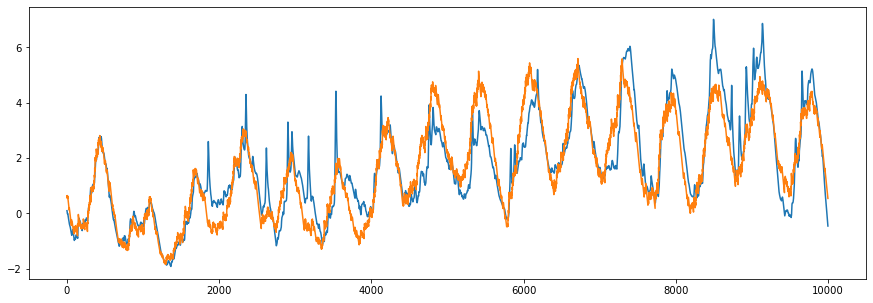

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

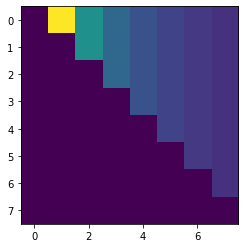

In [10]:
plt.imshow(test_C_den.cpu().detach().numpy())

In [12]:
print(model.C_den_raw.cpu().detach().numpy())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
